# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Data exploration

Load the dataset into a Pandas DataFrame.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


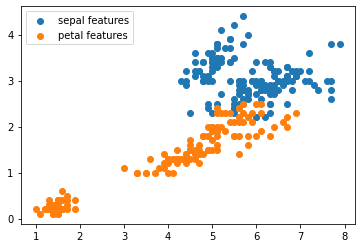

In [3]:
plt.scatter(df.sepal_length, df.sepal_width, label='sepal features')
plt.scatter(df.petal_length, df.petal_width, label='petal features')
plt.legend()

# Building the model 

For this problem we will use a XYZ model.